In [1]:
canvas_config = {
    'start_x' :30,
    'start_y' : 750,
    'token_spacing' : 100,
    'line_spacing' : 8,
  'count' : 0,
  'key_spacing' : 200,
  'header_spacing' : 15,
  'section_spacing' : 50,
  'line_break' : 20
}

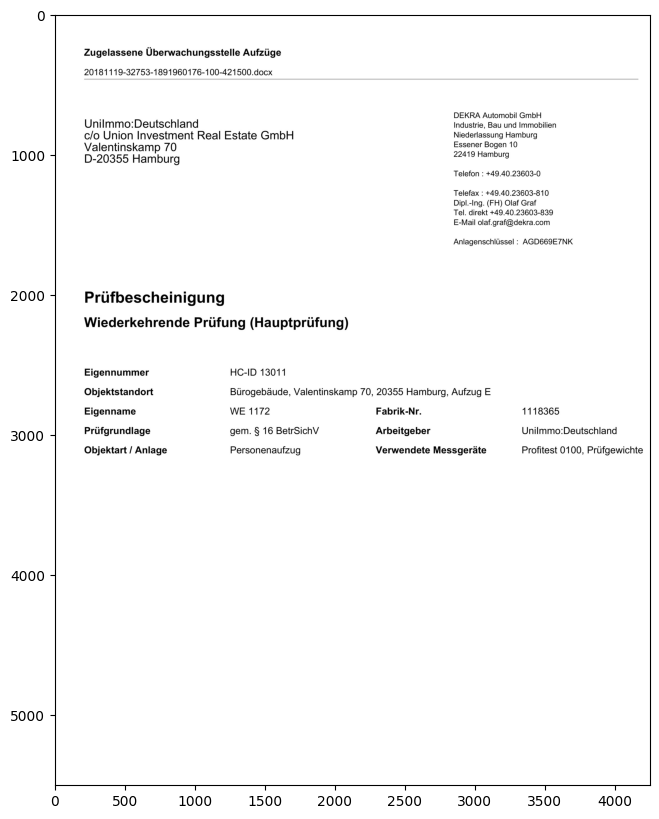

In [2]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas as Canvas
import cv2
import matplotlib.pyplot as plt 
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from PIL import Image
from pdf2image import convert_from_path
from reportlab.lib.colors import HexColor
from reportlab.lib import colors
import os
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch
import numpy as np
from reportlab.lib.pagesizes import A4
import random

# register the TTF font file
pdfmetrics.registerFont(TTFont('Arial', 'arial.ttf'))
pdfmetrics.registerFont(TTFont('Arial-Bold', 'arialbd.ttf'))

header = 'Zugelassene Überwachungsstelle Aufzüge'
file_name = '20181119-32753-1891960176-100-421500.docx'
page_no = 'Seite 1 von 1'

client_address = {
  'line1' : 'UniImmo:Deutschland',
  'line2' : 'c/o Union Investment Real Estate GmbH',
  'line3' : 'Valentinskamp 70',
  'line4' : 'D-20355 Hamburg'
}

client_address_config ={
  'font' : 'Arial',
  'line_break' : 12,
  'font_size' : 12
}

evaluator_address = {
  'address' :{
    'line1' : 'DEKRA Automobil GmbH',
    'line2' : 'Industrie, Bau und Immobilien',
    'line3' : 'Niederlassung Hamburg',
    'line4' : 'Essener Bogen 10',
    'line5' : '22419 Hamburg'
    },
  'Telefon' : '+49.40.23603-0',
  'Telefax' : '+49.40.23603-810',
  'Kontakt' : {
    'line1' : 'Dipl.-Ing. (FH) Olaf Graf',
    'line2' :'Tel. direkt +49.40.23603-839',
    'line3' : 'E-Mail olaf.graf@dekra.com',
  },
  
  'Anlagenschlüssel' : ' AGD669E7NK'
}

evaluator_address_config = {
  'font':'Arial',
  'line_break' : 10,
  'font_size' : 8,
  'new_line':['Telefax', 'kontakt']
}

test_certificate = {
  'Prüfbescheinigung' : 'Wiederkehrende Prüfung (Hauptprüfung)'
}

test_certificate_config = {
  'font_size' : 16,
  'font_type': 'Arial-Bold',
  'line-break' : 25 # should be 25-30
}

test_certificate_results = {
  'Prüfgrundlage' : 'gem. § 16 BetrSichV', #Str some code related to legal documents
  'Objektstandort' : 'Bürogebäude, Valentinskamp 70, 20355 Hamburg, Aufzug E', #str address
  'Objektart / Anlage' : 'Personenaufzug', #Str type of elevator
  'Fabrik-Nr.' : '1118365', #long 6-9 digits
  'Arbeitgeber' : client_address['line1'],
  'Eigennummer' : 'HC-ID 13011', # str(2)-str(2) 5 digit number,
  'Eigenname' : 'WE 1172',
  'Verwendete Messgeräte' : 'Profitest 0100, Prüfgewichte', ## Not clear str followed by some 4 digit num and then str 
}

test_certificate_results_config = {
  'font_size' : 10,
  'font-type-keys' : 'Arial-Bold',
  'font-type-vals' : 'Arial',
  'vertical-left-only' : ['Objektstandort', 'Arbeitgeber'],
  'line-break' : 20,
  'key-val-spacing': 150
  
}

def next_line(start_y, line_break):
  return start_y - line_break

def rearange_key_vals_test_results(dict_list, keys_to_keep, indices): ## keys which needs to appear either of the positions mentioned in indices usually 1,6
  for i , (key, val) in enumerate(dict_list):
    if key in keys_to_keep and i not in indices:
      swap_index = random.choice(indices) if len(indices) > 1 else indices[0] 
      dict_list[i], dict_list[swap_index] = dict_list[swap_index], dict_list[i]
      if len(indices)> 1 :
        indices.pop(indices.index(swap_index))
    
  return dict_list

def draw_client_address(client_address, canvas, x, y):
  canvas.setFont(client_address_config['font'], client_address_config['font_size'])
  keys_sorted = [key for key in client_address.keys()]
  
  for key in keys_sorted:
    canvas.drawString(x, y, client_address[key])
    y = next_line(y, client_address_config['line_break'])
  return x, y

def draw_evaluator_address(evaluator_address, evaluator_address_config, canvas, x, y, y_temp):
  canvas.setFont(evaluator_address_config['font'], evaluator_address_config['font_size'])
  start_x_temp = random.choice(np.arange(400,430, 10))
  y = y_temp
  count = 0
  for key in evaluator_address.keys():
    if not type(evaluator_address[key]) == dict: 
      canvas.drawString(start_x_temp, y, key + ' : ' + evaluator_address[key])
      count += 1
      y = next_line(y, evaluator_address_config['line_break'])
    else:
      for k in evaluator_address[key].keys():
        canvas.drawString(start_x_temp, y, evaluator_address[key][k])
        count += 1
        y = next_line(y, evaluator_address_config['line_break'])
    if count%5==0 or count%3==0: # Adding random new lines
      y = next_line(y, evaluator_address_config['line_break'])
  return x, y

def draw_test_certificate_results(test_certificate_results, test_certificate_results_config, canvas, x, y):
  items_test_certificate_results = list(test_certificate_results.items())
  random.shuffle(items_test_certificate_results)
  items_test_certificate_results = rearange_key_vals_test_results(items_test_certificate_results, test_certificate_results_config['vertical-left-only'], [1,6])
  start_x_temp = x
  new_lines = []
  for i , (key, val) in enumerate(items_test_certificate_results):
    if i in (5,6) and key not in test_certificate_results_config['vertical-left-only']:
      start_x_temp = start_x_temp + 2* test_certificate_results_config['key-val-spacing']
      y = new_lines[-3]
    canvas.setFont(test_certificate_results_config['font-type-keys'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp, y , key)
    #start_x_temp = start_x_temp + test_certificate_results_config['key-val-spacing']
    canvas.setFont(test_certificate_results_config['font-type-vals'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp + test_certificate_results_config['key-val-spacing'], y, val)
    new_lines.append(y)
    y = next_line(y, test_certificate_results_config['line-break'])
  
  return x, y 
  
def draw_report(header:dict=None, report_name:str='form.pdf', image_path:str = None):
  
  start_x = 30
  start_x_temp = start_x
  start_y = 750
  start_y_temp = start_y
  token_spacing = 100
  line_spacing = 8
  count = 0
  key_spacing = 200
  header_spacing = 15
  section_spacing = 50
  line_break = 20

  
  c = Canvas(report_name)
  canvas = c
  canvas.setPageSize(letter)
  canvas.setLineWidth(.3)
  canvas.setFont('Arial-Bold', 10) 
  
  canvas.setFillColor(HexColor(0x000000))
  canvas.drawString(start_x,start_y, header) # start_x = 30, start_y = 750, font_size = 10  
  canvas.setFont('Arial', 9)
  
  new_line = next_line(start_y, line_break)
  
  canvas.drawString(start_x,new_line, file_name)
  
  new_line = next_line(new_line, 4)
  canvas.line(start_x, new_line, 600, new_line)
  
  ## Section Spacing
  new_line = next_line(new_line, section_spacing)
  
  ## Used for evaluator address
  new_line_temp = new_line + 10
  
  # Section 1
  ## Client Address
  
  _, new_line = draw_client_address(client_address, canvas, start_x, new_line)

  #canvas.line(480,747,580,747)
  
  #Section 2
  _, new_line = draw_evaluator_address(evaluator_address, evaluator_address_config, canvas, start_x, new_line, new_line_temp)  
  
  ## Section 3 test_certificate
  new_line = next_line(new_line, section_spacing)
  canvas.setFont(test_certificate_config['font_type'], test_certificate_config['font_size'])
  canvas.drawString(start_x, new_line, list(test_certificate.keys())[0])
  new_line = next_line(new_line, test_certificate_config['line-break'])
  canvas.setFont(test_certificate_config['font_type'], test_certificate_config['font_size'] - 2)
  canvas.drawString(start_x, new_line, test_certificate['Prüfbescheinigung'])
  
  ## Section 4 test_certificate_results
  new_line = next_line(new_line, section_spacing)
  
  _, new_line = draw_test_certificate_results(test_certificate_results, test_certificate_results_config, canvas, start_x, new_line)
  '''items_test_certificate_results = list(test_certificate_results.items())
  random.shuffle(items_test_certificate_results)
  items_test_certificate_results = rearange_key_vals_test_results(items_test_certificate_results, test_certificate_results_config['vertical-left-only'], [1,6])
  
  
  start_x_temp = start_x
  new_lines = []
  for i , (key, val) in enumerate(items_test_certificate_results):
    if i in (5,6) and key not in test_certificate_results_config['vertical-left-only']:
      start_x_temp = start_x_temp + 2* test_certificate_results_config['key-val-spacing']
      new_line = new_lines[-3]
    canvas.setFont(test_certificate_results_config['font-type-keys'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp, new_line , key)
    #start_x_temp = start_x_temp + test_certificate_results_config['key-val-spacing']
    canvas.setFont(test_certificate_results_config['font-type-vals'], test_certificate_results_config['font_size'])
    canvas.drawString(start_x_temp + test_certificate_results_config['key-val-spacing'], new_line, val)
    new_lines.append(new_line)
    new_line = next_line(new_line, test_certificate_results_config['line-break'])'''
    
      #new_line = new_line - 2* test_certificate_results_config['line-break']

  canvas.save()
  
draw_report(header=header, report_name='form.pdf')
pages = convert_from_path('form.pdf', 500)
pages[0].save(f'form.jpg', 'JPEG')
plt.figure(figsize = (200,10))
plt.imshow(cv2.imread('form.jpg')[:,:,::-1])

[('Tragfähigkeit', '1350 kg / 18 Pers'), ('Haltestellen / Zugangstellen', '26 / 26'), ('Antrieb / Aufhängung', 'Treibscheibe / 2:1'), ('Förderhöhe', '93,68 m'), ('Geschwindigkeit', '4,00 m/s'), ('Baujahr', 2011), ('Hersteller', 'Schindler Aufzüge und Fahrtreppen GmbH Region Nord'), ('Errichtungsgrundlage', 'EN 81-1: 1998+A3: 2009'), ('Wartungsfirma', 'Schindler Aufzüge und Fahrtreppen GmbH Region Nord')]
Tragfähigkeit, 1350 kg / 18 Pers
Haltestellen / Zugangstellen, 26 / 26
Antrieb / Aufhängung, Treibscheibe / 2:1
Förderhöhe, 93,68 m
Geschwindigkeit, 4,00 m/s
Baujahr, 2011
Hersteller, Schindler Aufzüge und Fahrtreppen GmbH Region Nord
Errichtungsgrundlage, EN 81-1: 1998+A3: 2009
Wartungsfirma, Schindler Aufzüge und Fahrtreppen GmbH Region Nord


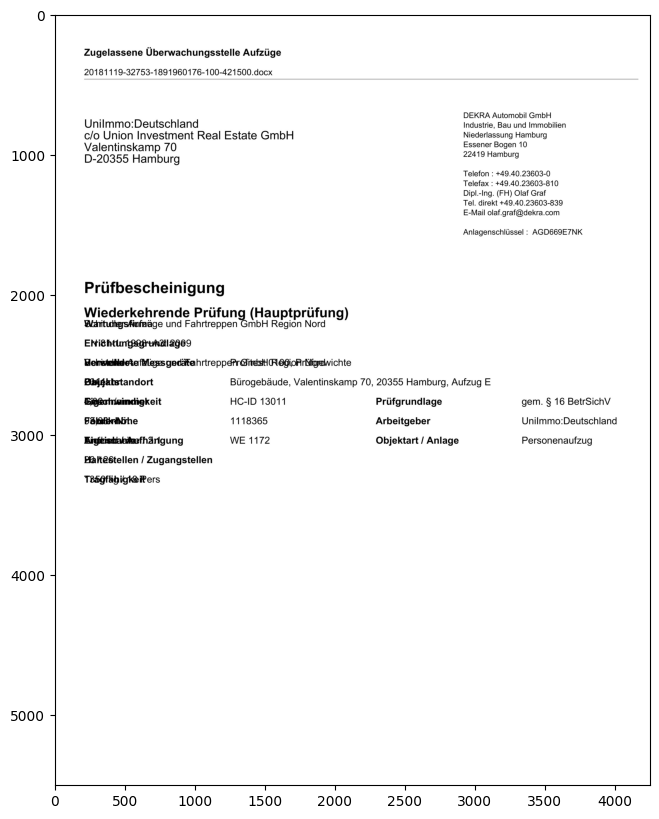

In [15]:
from template1 import Template_Dekra

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen.canvas import Canvas as Canvas
import cv2
import matplotlib.pyplot as plt 
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from PIL import Image
from pdf2image import convert_from_path
from reportlab.lib.colors import HexColor
from reportlab.lib import colors
import os
from reportlab.lib.utils import ImageReader
from reportlab.lib.units import inch
import numpy as np
from reportlab.lib.pagesizes import A4
import random

start_x = 30
start_x_temp = start_x
start_y = 750
start_y_temp = start_y
token_spacing = 100
line_spacing = 8
count = 0
key_spacing = 200
header_spacing = 15
section_spacing = 50
line_break = 20

file_name='form.pdf'
header = 'Zugelassene Überwachungsstelle Aufzüge'
file_name = '20181119-32753-1891960176-100-421500.docx'
report_name = 'form.pdf'
page_no = 'Seite 1 von 1'

template1 = Template_Dekra(start_x = start_x,
        start_y = start_y,
        token_spacing = token_spacing,
        line_spacing = line_spacing,
        key_spacing = key_spacing,
        header_spacing = header_spacing,
        section_spacing = section_spacing,
        line_break = line_break,
        header = header,
        file_name = file_name,
        page_no = page_no)
#draw_report(header=header, report_name='form.pdf')

template1.draw_report(header=header, report_name='form.pdf')
pages = convert_from_path('form.pdf', 500)
pages[0].save(f'form.jpg', 'JPEG')
plt.figure(figsize = (200,10))
plt.imshow(cv2.imread('form.jpg')[:,:,::-1])

Confidence: 91
Text: Zugelassene

Confidence: 91
Text: Überwachungsstelle

Confidence: 96
Text: Aufzüge

Confidence: 90
Text: 20181119-32753-1891960176-100-421500.docx

Confidence: 95
Text:  

Confidence: 92
Text: DEKRA

Confidence: 96
Text: Automobil

Confidence: 96
Text: GmbH

Confidence: 91
Text: Unilmmo:Deutschland

Confidence: 96
Text: Industrie,

Confidence: 96
Text: Bau

Confidence: 96
Text: und

Confidence: 95
Text: Immobilien

Confidence: 96
Text: c/o

Confidence: 96
Text: Union

Confidence: 96
Text: Investment

Confidence: 96
Text: Real

Confidence: 96
Text: Estate

Confidence: 95
Text: GmbH

Confidence: 96
Text: Niederlassung

Confidence: 96
Text: Hamburg

Confidence: 91
Text: Valentinskamp

Confidence: 68
Text: 7O

Confidence: 96
Text: Essener

Confidence: 96
Text: Bogen

Confidence: 96
Text: 10

Confidence: 96
Text: D-20355

Confidence: 96
Text: Hamburg

Confidence: 96
Text: 22419

Confidence: 96
Text: Hamburg

Confidence: 93
Text: Telefon

Confidence: 92
Text: :

Confiden

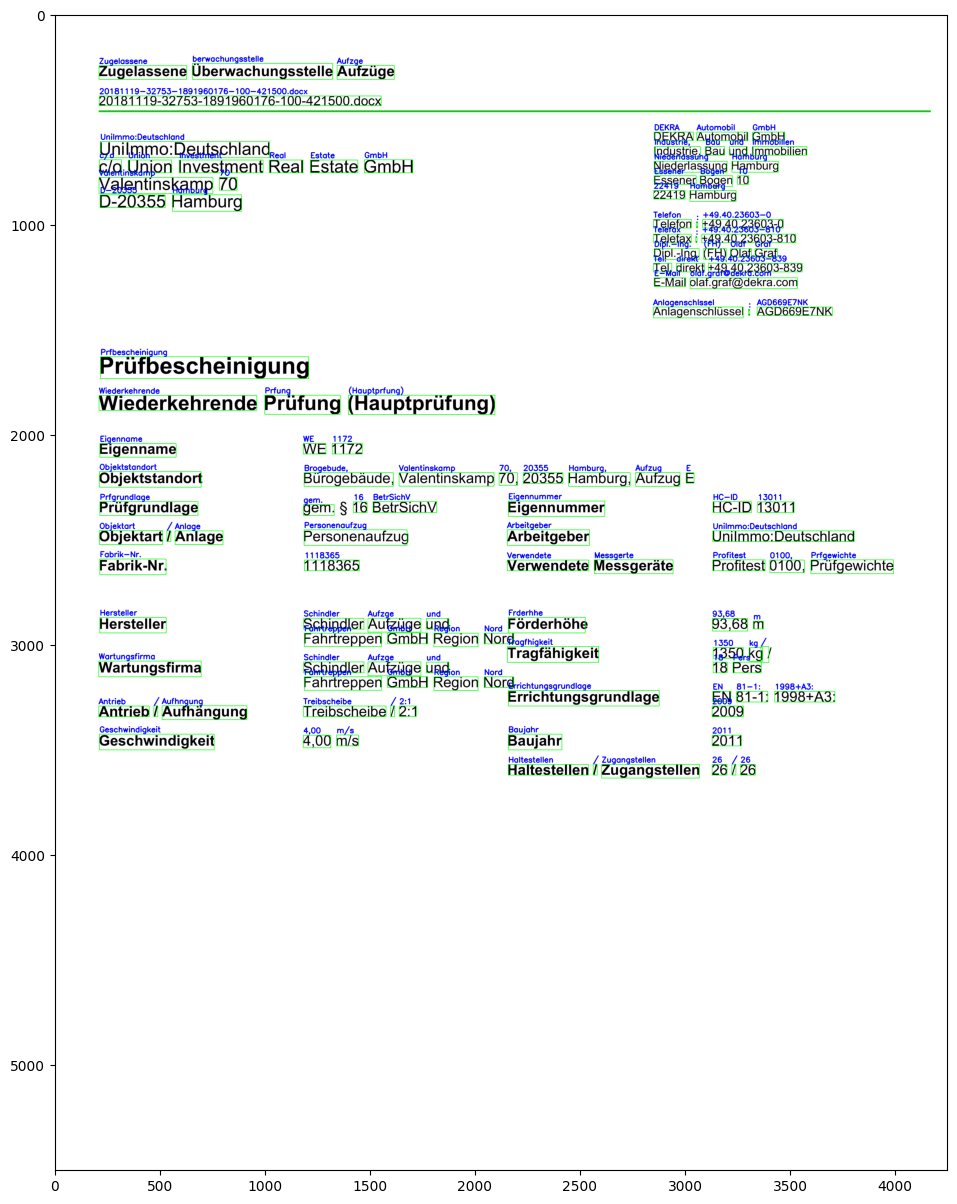

In [19]:
import pytesseract
from pytesseract import Output
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('form.jpg')

results = pytesseract.image_to_data(image, output_type=Output.DICT, lang='deu')
n_boxes = len(results['level'])
tokens = []
bboxes = []

tokens = {'text' : [], 'bbox':[]}
for i in range(n_boxes):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
    text = results["text"][i]
    
    conf = int(results["conf"][i])
    #(x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if conf > 50:
        # display the confidence and text to our terminal
        #tokens.append((text, [x + w, y + h]))
        tokens.append(text)
        bboxes.append([x,y,x+w, y+h])
        print("Confidence: {}".format(conf))
        print("Text: {}".format(text))
        print("")
		# strip out non-ASCII text so we can draw the text on the image
		# using OpenCV, then draw a bounding box around the text along
		# with the text itself
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    1.2, (0, 0, 255), 3)

plt.figure(figsize = (250,15))
plt.imshow(image)
#cv2.waitKey(0)

In [33]:
from transformers import AutoTokenizer, LayoutLMv2ForRelationExtraction
model = LayoutLMv2ForRelationExtraction.from_pretrained("microsoft/layoutxlm-base")
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutxlm-base")
print(len(tokens))
print(len(bboxes))
input_ids = tokenizer.encode(text = tokens, boxes = bboxes, is_pretokenized=False)
print(input_ids)

NameError: name 'LayoutLMv2ForRelationExtraction' is not defined

In [6]:
print(len(tokens))
tokens = [token for token in tokens if token != ' ']
print(len(tokens))

130
129


In [ ]:
new_tokens = tokens

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# add the tokens to the tokenizer vocabulary
tokenizer.add_tokens(list(new_tokens))

# add new, random embeddings for the new tokens
model.resize_token_embeddings(len(tokenizer))

In [32]:
for id in input_ids:
  print(tokenizer.decode([id]))

<s>
Zu
gelassen
e
Über
wach
ungs
stelle
Auf
züge
2018
11
19
-32
75
3-1
89
1960
176
-100
-42
1500
.
doc
x
DE
K
RA
Automobil
GmbH
Uni
lm
mo
:
De
u
tsch
land
Industrie
,
Bau
und
Immobilien
c
/
o
Union
Investment
Real
Estate
GmbH
Nieder
lassung
Hamburg
Valentin
s
kamp
7
O
Essen
er
Bog
en
10
D
-20
355
Hamburg
224
19
Hamburg
Telefon
:
+
49
.
40
.
2
360
3
-0
Tele
fax
:
+
49
.
40
.
2
360
3-8
10
Di
pl
.
-
Ing
.
(
F
H
)
O
laf
Graf
Tel
.
direkt
+
49
.
40
.
2
360
3-8
39
E
-
Mail
o
laf
.
graf
@
de
kra
.
com
Anlage
n
schlüsse
l
:
A
GD
669
E
7
NK
Prüf
be
schein
igung
Wieder
kehr
ende
Prüfung
(
Ha
up
t
prüfung
)
Eigen
name
WE
11
72
Objekt
stand
ort
Büro
gebäude
,
Valentin
s
kamp
70
,
20
355
Hamburg
,
Auf
zug
E
Prüf
grund
lage
gem
.
16
Bet
r
S
ich
V
Eigen
nummer
HC
-
ID
130
11
Objekt
art
/
Anlage
Personen
auf
zug
Arbeitgeber
Uni
lm
mo
:
De
u
tsch
land
Fabrik
-
N
r
.
11
18
365
Ver
wende
te
Mess
geräte
Profit
est
0
100
,
Prüf
gewicht
e
Hersteller
Sch
ind
ler
Auf
züge
und
Förder
höhe
93
,
68
m
Fahrt
re
pp

In [16]:
from transformers import LayoutXLMProcessor
from PIL import Image

processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base")

image = Image.open(
    "form.jpg"
).convert("RGB")
encoding = processor(
    image, return_tensors="pt"
)  # you can also add all tokenizer parameters here such as padding, truncation
print(encoding.keys())


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like microsoft/layoutxlm-base is not the path to a directory containing a file named preprocessor_config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.